In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

dqn_eval_trip_files = [
    "tripinfo_eval_offline_4act_ep1.xml", 
    "tripinfo_eval_offline_4act_ep2.xml",
    "tripinfo_eval_offline_4act_ep3.xml"
]
dqn_eval_summary_files = [
    "summary_eval_offline_4act_ep1.xml",
    "summary_eval_offline_4act_ep2.xml",
    "summary_eval_offline_4act_ep3.xml"
]

# Baseline files
baseline_files = [
    ("Fixed-Time", "tripinfo_fixed_time.xml", "summary_fixed_time.xml"),
    ("Rule-Based", "tripinfo_rule_based.xml", "summary_rule_based.xml")
]

# Check if all specified files exist
all_files_to_check = []
for label, trip, summ in baseline_files:
    all_files_to_check.extend([trip, summ])
all_files_to_check.extend(dqn_eval_trip_files)
all_files_to_check.extend(dqn_eval_summary_files)

missing_files = [f for f in all_files_to_check if not os.path.exists(f)]
if missing_files:
    print("ERROR: The following result files are missing. Please generate them or update paths:")
    for f_missing in missing_files:
        print(f" - {f_missing}")
else:
    print("All specified result files found.")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

All specified result files found.


In [ ]:
def parse_tripinfo(file_path):
    """Parses a SUMO tripinfo XML file and returns a list of dictionaries."""
    if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
        print(f"Warning: Tripinfo file '{file_path}' not found or empty. Skipping.")
        return []
        
    tree = ET.parse(file_path)
    root = tree.getroot()
    trips_data = []
    for tripinfo in root.findall('tripinfo'):
        try:
            data = {
                'id': tripinfo.get('id'),
                'depart': float(tripinfo.get('depart')),
                'arrival': float(tripinfo.get('arrival', -1)),
                'duration': float(tripinfo.get('duration')),
                'routeLength': float(tripinfo.get('routeLength')),
                'waitingTime': float(tripinfo.get('waitingTime')),
                'waitingCount': int(tripinfo.get('waitingCount')),
                'timeLoss': float(tripinfo.get('timeLoss')),
                'departLane': tripinfo.get('departLane'),
                'arrivalLane': tripinfo.get('arrivalLane'),
                'departSpeed': float(tripinfo.get('departSpeed')),
                'arrivalSpeed': float(tripinfo.get('arrivalSpeed', -1)),
                'vType': tripinfo.get('vType', 'N/A')
            }
            if data['arrival'] != -1:
                trips_data.append(data)
        except (TypeError, ValueError) as e:
            print(f"Warning: Skipping trip due to parsing error in {file_path}: {e} for trip {tripinfo.get('id')}")
            continue
    return trips_data

def parse_summary(file_path):
    """Parses a SUMO summary XML file and returns a dictionary of summary stats."""
    if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
        print(f"Warning: Summary file '{file_path}' not found or empty. Skipping.")
        return {}
        
    tree = ET.parse(file_path)
    root = tree.getroot()
    summary_data = {}
    try:
        step_data = root.find('step')
        if step_data is not None:
            summary_data = {
                'time': float(step_data.get('time')),
                'loaded': int(step_data.get('loaded')),
                'inserted': int(step_data.get('inserted')),
                'running': int(step_data.get('running')),
                'waiting': int(step_data.get('waiting')),
                'ended': int(step_data.get('ended')),
                'meanWaitingTime': float(step_data.get('meanWaitingTime', 0)),
                'meanTravelTime': float(step_data.get('meanTravelTime', 0)),
                'meanSpeed': float(step_data.get('meanSpeed', 0)),
            }
    except Exception as e:
        print(f"Warning: Error parsing summary file {file_path}: {e}")
    return summary_data

def calculate_trip_metrics(trips_data_list):
    """Calculates aggregated metrics from a list of trip data (parsed from one or more files)."""
    if not trips_data_list:
        return {
            'total_completed_trips': 0,
            'avg_trip_duration': 0,
            'avg_waiting_time': 0,
            'avg_time_loss': 0,
            'avg_route_length': 0,
            'total_waiting_time': 0,
            'simulation_end_time': 0,
            'throughput_per_hour': 0
        }

    df = pd.DataFrame(trips_data_list)
    
    total_completed = len(df)
    avg_duration = df['duration'].mean() if total_completed > 0 else 0
    avg_wait_time = df['waitingTime'].mean() if total_completed > 0 else 0
    avg_time_loss = df['timeLoss'].mean() if total_completed > 0 else 0
    avg_route_len = df['routeLength'].mean() if total_completed > 0 else 0
    total_wait_time_sum = df['waitingTime'].sum() if total_completed > 0 else 0

    sim_end_time = df['arrival'].max() if total_completed > 0 else 0
    throughput_ph = (total_completed / (sim_end_time / 3600.0)) if sim_end_time > 0 else 0
    
    return {
        'total_completed_trips': total_completed,
        'avg_trip_duration': avg_duration,
        'avg_waiting_time': avg_wait_time,
        'avg_time_loss': avg_time_loss,
        'avg_route_length': avg_route_len,
        'total_waiting_time': total_wait_time_sum,
        'simulation_end_time': sim_end_time,
        'throughput_per_hour': throughput_ph
    }

In [ ]:
all_metrics_data = []
dqn_all_trips = []
for trip_file in dqn_eval_trip_files:
    dqn_all_trips.extend(parse_tripinfo(trip_file))

if dqn_all_trips:
    dqn_avg_metrics = calculate_trip_metrics(dqn_all_trips)
    dqn_avg_metrics['label'] = "DQN Agent (Avg)"
    all_metrics_data.append(dqn_avg_metrics)
else:
    print("Warning: No DQN trip data found to process.")

# Process baseline files
for label, trip_file, summary_file in baseline_files:
    trips = parse_tripinfo(trip_file)
    if trips:
        metrics = calculate_trip_metrics(trips)
        metrics['label'] = label
        all_metrics_data.append(metrics)
    else:
        print(f"Warning: No trip data found for baseline '{label}'.")

if all_metrics_data:
    metrics_df = pd.DataFrame(all_metrics_data)
    metrics_df = metrics_df.set_index('label')
    print("\n--- Calculated Metrics ---")
    print(metrics_df[['total_completed_trips', 'avg_waiting_time', 'avg_trip_duration', 'throughput_per_hour', 'avg_time_loss']])
else:
    print("\nNo metrics data was processed. Ensure XML files are present and paths are correct.")
    metrics_df = pd.DataFrame()


--- Calculated Metrics ---
                 total_completed_trips  avg_waiting_time  avg_trip_duration  \
label                                                                         
DQN Agent (Avg)                   5955         60.100588          91.009068   
Fixed-Time                        2275         61.638681          88.141978   
Rule-Based                        3107         19.031864          48.356936   

                 throughput_per_hour  avg_time_loss  
label                                                
DQN Agent (Avg)          5956.654626      75.361874  
Fixed-Time               2275.632120      73.331705  
Rule-Based               3107.863295      33.371172  


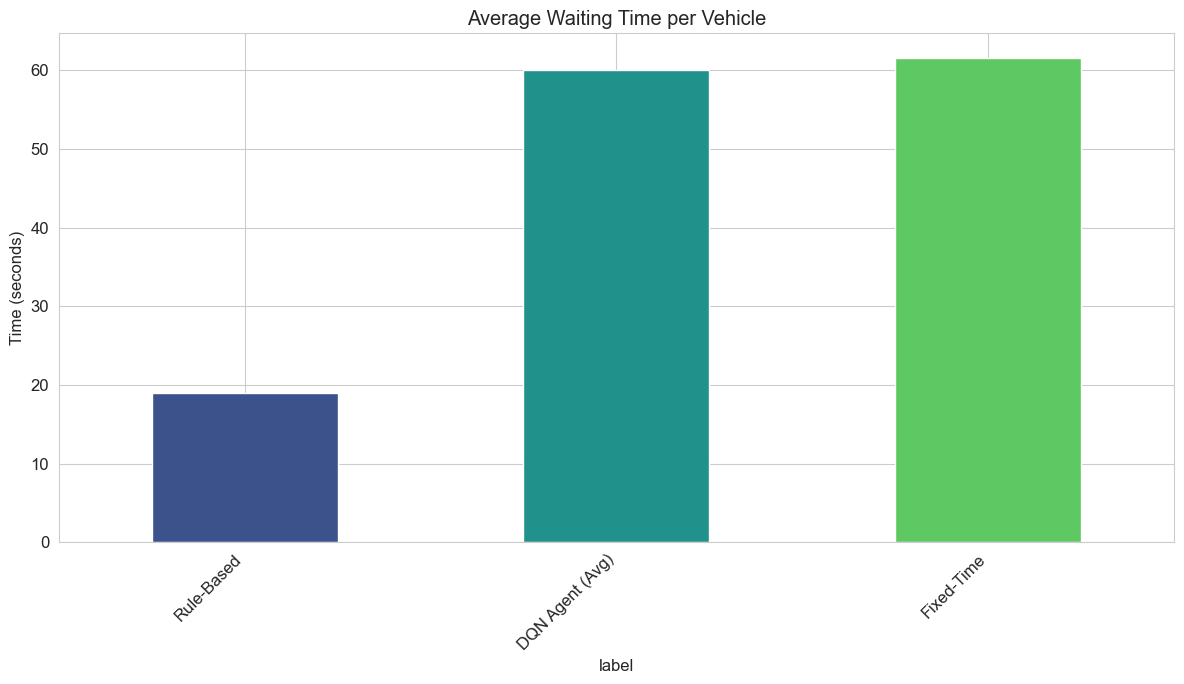

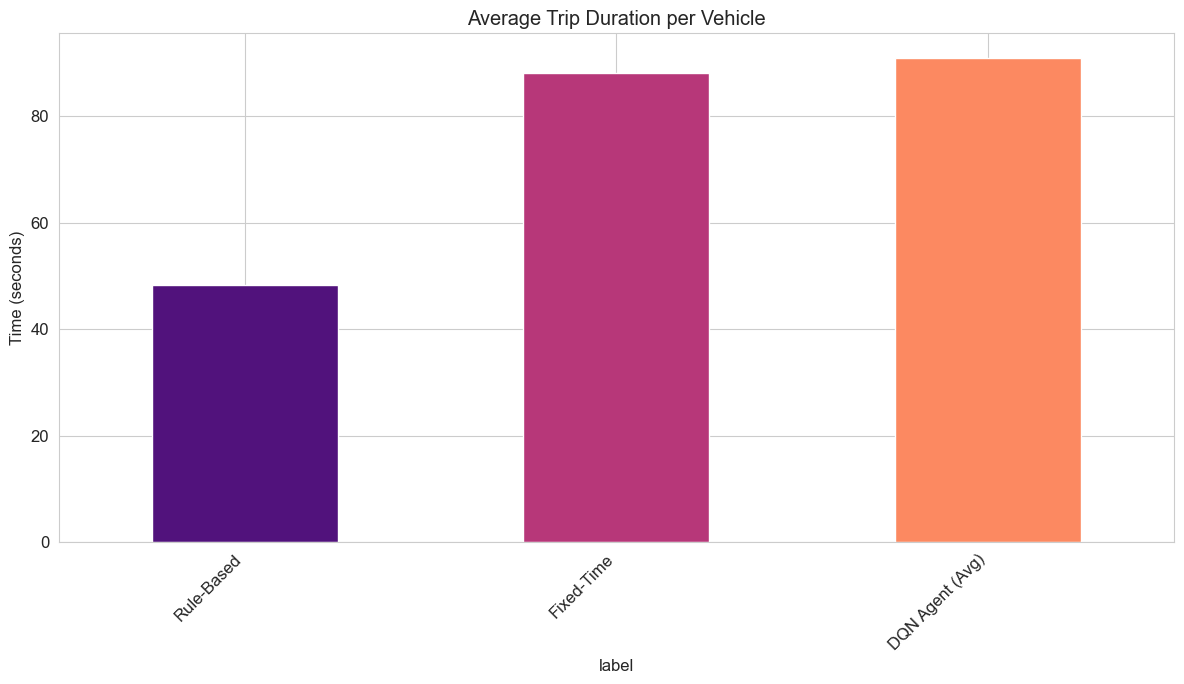

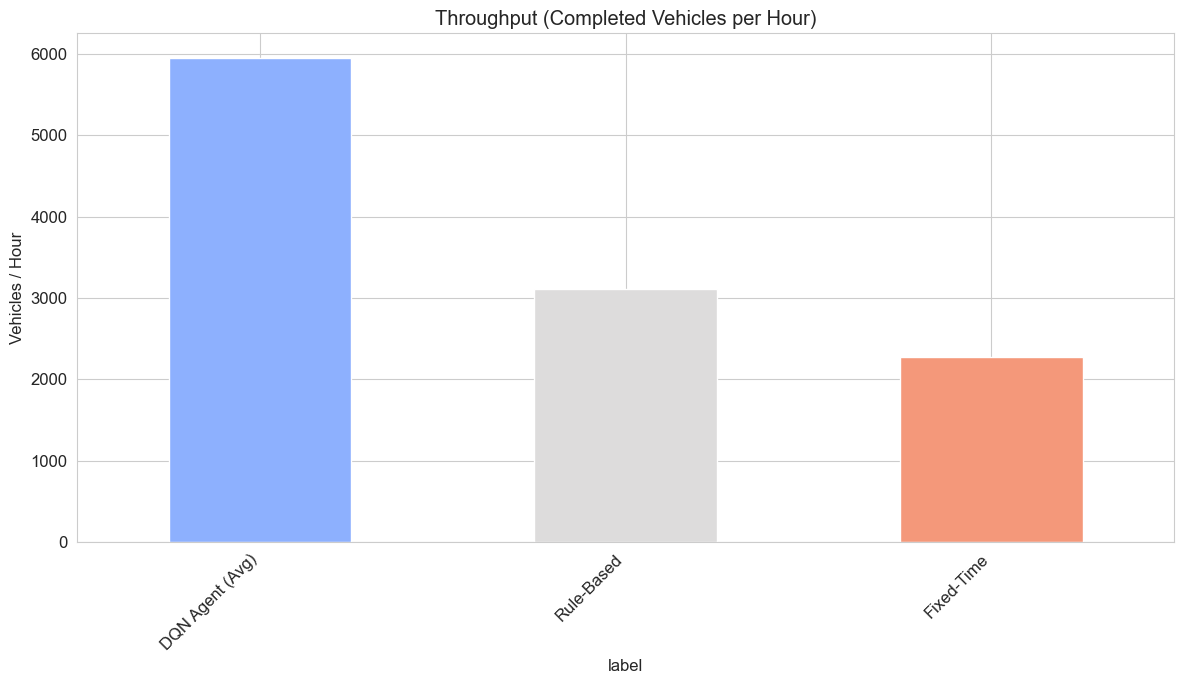

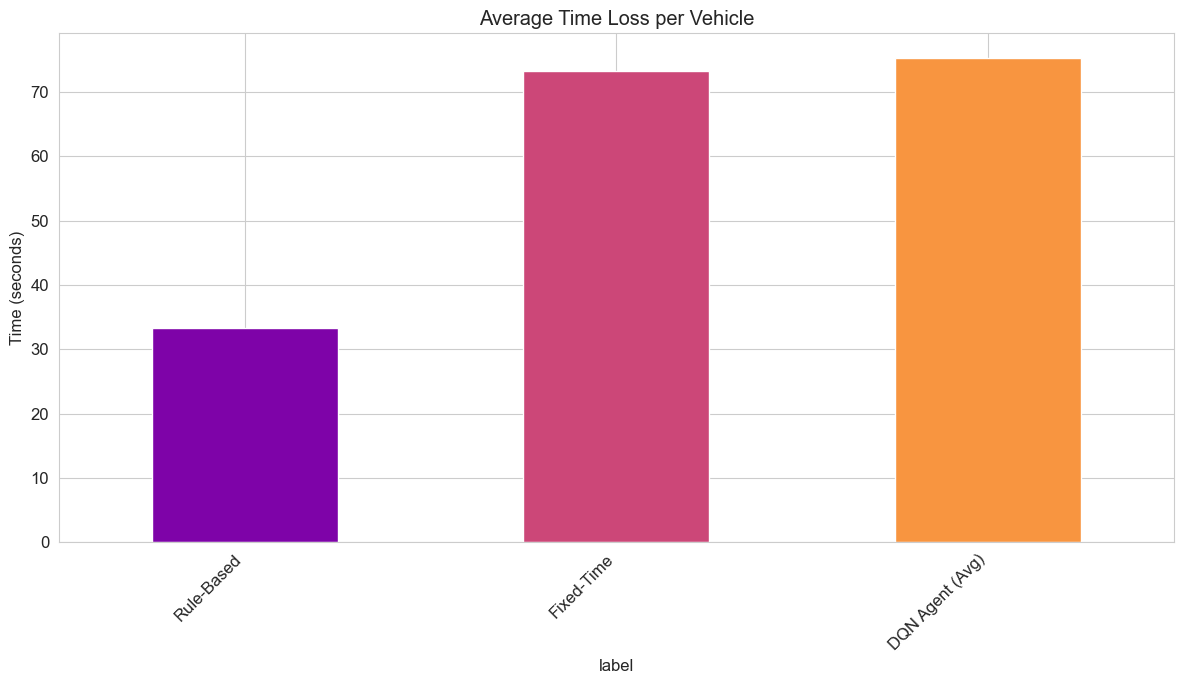

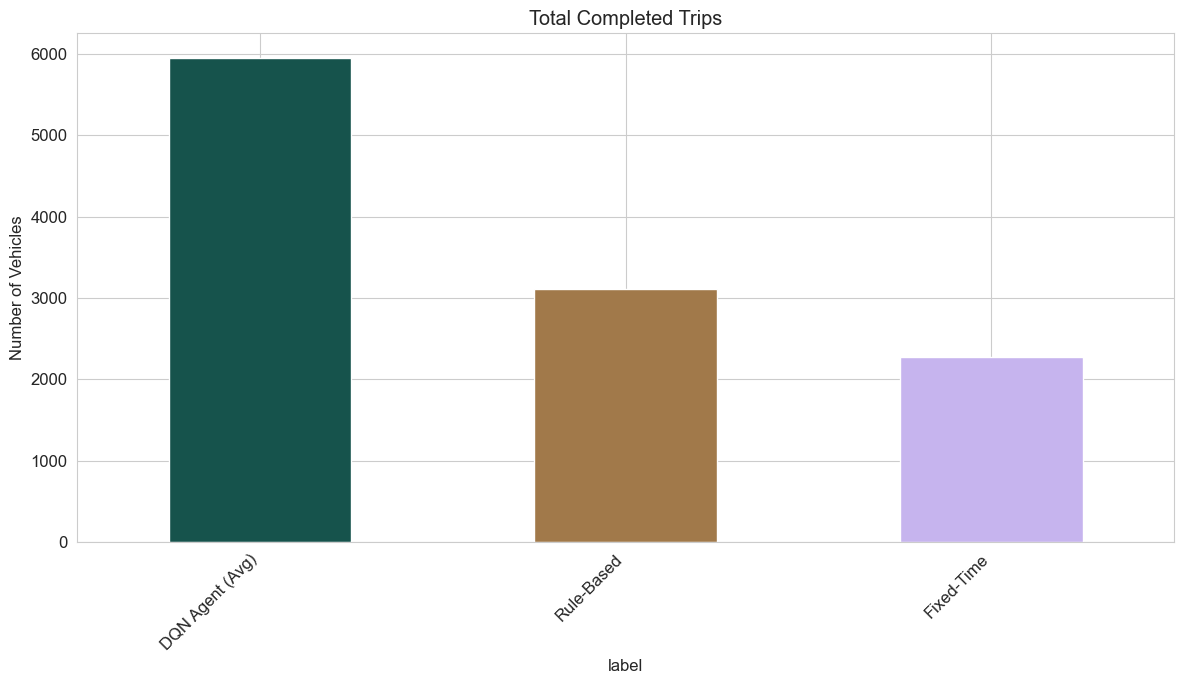

In [6]:
if not metrics_df.empty:
    # --- Bar Chart: Average Waiting Time ---
    plt.figure()
    metrics_df['avg_waiting_time'].sort_values().plot(kind='bar', color=sns.color_palette("viridis", len(metrics_df)))
    plt.title('Average Waiting Time per Vehicle')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Bar Chart: Average Trip Duration ---
    plt.figure()
    metrics_df['avg_trip_duration'].sort_values().plot(kind='bar', color=sns.color_palette("magma", len(metrics_df)))
    plt.title('Average Trip Duration per Vehicle')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Bar Chart: Throughput (Vehicles per Hour) ---
    plt.figure()
    metrics_df['throughput_per_hour'].sort_values(ascending=False).plot(kind='bar', color=sns.color_palette("coolwarm", len(metrics_df)))
    plt.title('Throughput (Completed Vehicles per Hour)')
    plt.ylabel('Vehicles / Hour')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    # --- Bar Chart: Average Time Loss ---
    plt.figure()
    metrics_df['avg_time_loss'].sort_values().plot(kind='bar', color=sns.color_palette("plasma", len(metrics_df)))
    plt.title('Average Time Loss per Vehicle')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Bar Chart: Total Completed Trips ---
    plt.figure()
    metrics_df['total_completed_trips'].sort_values(ascending=False).plot(kind='bar', color=sns.color_palette("cubehelix", len(metrics_df)))
    plt.title('Total Completed Trips')
    plt.ylabel('Number of Vehicles')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

else:
    print("Skipping plotting as no metrics data is available.")

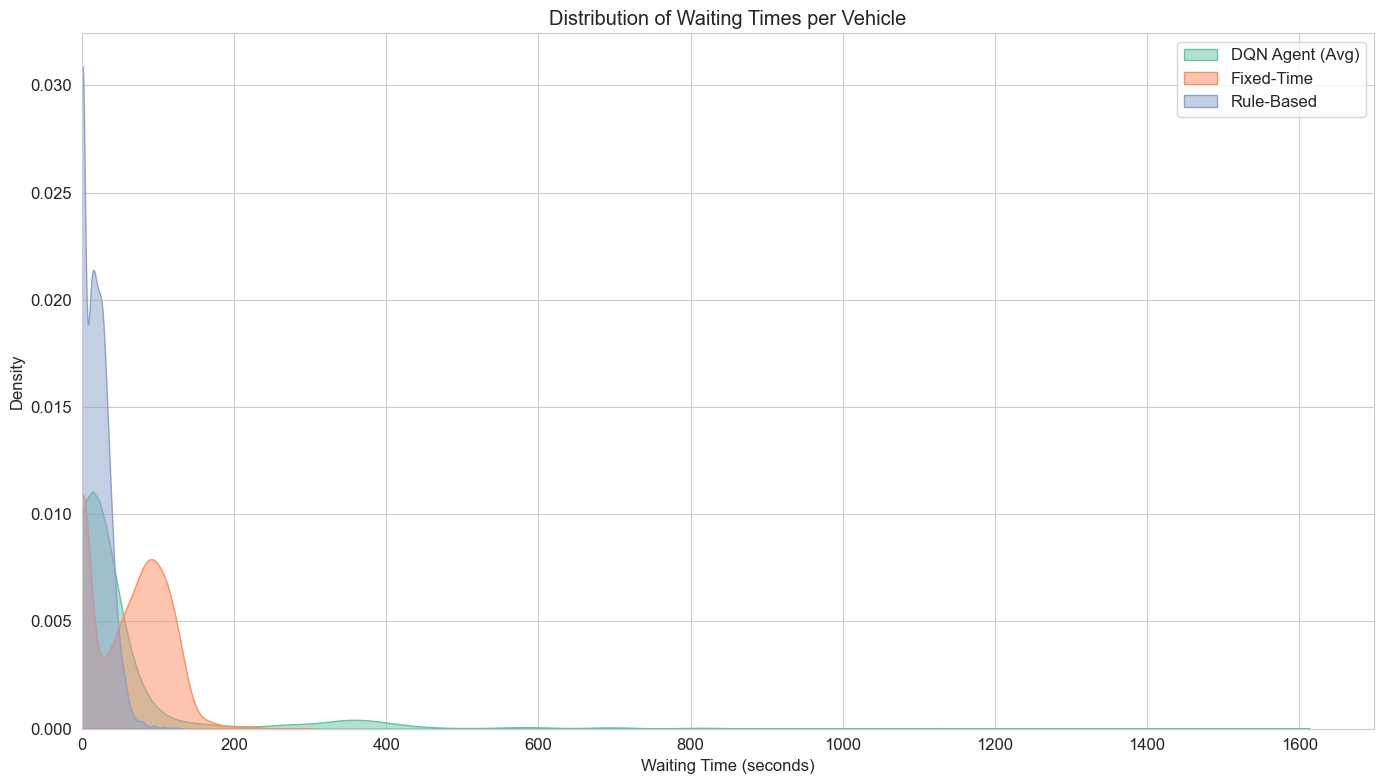

In [ ]:
if not metrics_df.empty:
    plt.figure(figsize=(14, 8))
    
    # Plot waiting time distributions
    all_trip_dfs = {}

    # DQN
    if dqn_all_trips: 
        df_dqn = pd.DataFrame(dqn_all_trips)
        if not df_dqn.empty:
            all_trip_dfs["DQN Agent (Avg)"] = df_dqn

    # Baselines
    for label, trip_file, _ in baseline_files:
        trips_data = parse_tripinfo(trip_file)
        if trips_data:
            df_baseline = pd.DataFrame(trips_data)
            if not df_baseline.empty:
                all_trip_dfs[label] = df_baseline
    
    plot_colors = sns.color_palette("Set2", len(all_trip_dfs))
    plot_idx = 0
    for label, df_indiv in all_trip_dfs.items():
        if 'waitingTime' in df_indiv.columns and not df_indiv['waitingTime'].empty:
            sns.kdeplot(df_indiv['waitingTime'], label=label, fill=True, alpha=0.5, color=plot_colors[plot_idx])
            plot_idx += 1
        else:
            print(f"No 'waitingTime' data to plot for {label}")

    if plot_idx > 0:
        plt.title('Distribution of Waiting Times per Vehicle')
        plt.xlabel('Waiting Time (seconds)')
        plt.ylabel('Density')
        plt.legend()
        plt.xlim(left=0)
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for waiting time distribution plot.")

else:
    print("Skipping distribution plots as no metrics data is available.")